# Atividade 04 - Inteligência Computacional
## Fabiano Dicheti

#### Aplicar um classificador na base de dados MNIST reduzida por Encoder, avaliando sua acurácia em conjuntos de treinamento e teste. 

## Usei um auto-encoder, peguei as imagens codificadas e usei para treinar uma CNN. 
## Para fazer as classificações,  no teste, primeiro codifico as imagens e então uso as imagens codificadas como input do modelo.
## Levou cerca de 2 horas para executar o script (treinamentos).
## O resultado foi  91,38% para treino e 91,51% para teste.
### obs: rodei local, não usei o colab.

## Importando as Bibliotecas

In [1]:
import tensorflow.keras
from  tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## Carregando os Dados, Separados em Conjunto de Teste e Treinamento

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

    
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [4]:
label_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',}


In [6]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

## Escalando o Valor dos Pixels das Imagens

In [7]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

## Definindo a proporcao dos conjuntos

In [8]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

## Definindo Parâmetros

In [9]:
batch_size = 64
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

## Arquitetura

In [10]:
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [14]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics = ['Accuracy'])
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_28 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 64)        1849

## Treinando a Arquitetura, Gerando Modelo

In [15]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/20
750/750 [==============================] - 348s 461ms/step - loss: 0.0200 - accuracy: 1.6568e-04 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 2/20
750/750 [==============================] - 333s 445ms/step - loss: 0.0083 - accuracy: 4.0205e-05 - val_loss: 0.0101 - val_accuracy: 3.4800e-04
Epoch 3/20
750/750 [==============================] - 366s 488ms/step - loss: 0.0067 - accuracy: 2.5882e-05 - val_loss: 0.0065 - val_accuracy: 6.9090e-06
Epoch 4/20
750/750 [==============================] - 368s 491ms/step - loss: 0.0059 - accuracy: 8.7160e-06 - val_loss: 0.0058 - val_accuracy: 1.8920e-05
Epoch 5/20
750/750 [==============================] - 365s 486ms/step - loss: 0.0050 - accuracy: 1.4509e-05 - val_loss: 0.0099 - val_accuracy: 0.0011
Epoch 6/20
750/750 [==============================] - 293s 390ms/step - loss: 0.0045 - accuracy: 9.0614e-06 - val_loss: 0.0043 - val_accuracy: 1.9143e-04
Epoch 7/20
750/750 [==============================] - 296s 395ms/step - loss: 0.

## Verificando Acurácia

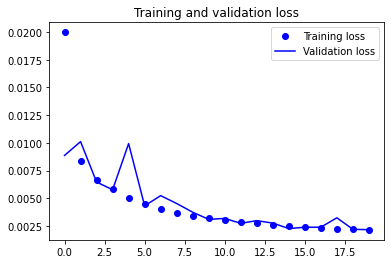

In [16]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Mudando os Rotulos Para matriz Booleana

In [17]:
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

print('Rotulo Original:', train_labels[0])
print('Novo Rotulo:', train_Y_one_hot[0])

Rotulo Original: 9
Novo Rotulo: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Preparando Dados de Teste e Treino Para o Classificador

In [19]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

## Redefinindo o Econder para usar dentro do Classificador

In [20]:
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

## Criando a Funcao do Flatten

In [21]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [22]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [23]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

## Conferindo os Pesos do Autoencoder Com os do Flatten 
### (A Tem que dar igual)

In [24]:
autoencoder.get_weights()[0][1]

array([[[ 0.16951415,  0.09679259,  0.0158539 , -0.02957525,
         -0.02990372,  0.11645889, -0.18873233,  0.03171581,
         -0.13561404, -0.05133811,  0.16859603,  0.03148628,
         -0.12885311, -0.15046698,  0.10007538, -0.08050466,
          0.09015167, -0.18901101, -0.02619152,  0.08439263,
          0.09931664, -0.06642337, -0.2388582 , -0.01337829,
          0.41621152, -0.07912167,  0.2905025 ,  0.10266475,
         -0.11804989, -0.03196193, -0.23477376, -0.1796494 ]],

       [[ 0.25610337, -0.03079755, -0.17623153,  0.08841568,
          0.19260746, -0.05464605,  0.0362807 ,  0.08535143,
         -0.06896732,  0.14356977,  0.143526  , -0.2691078 ,
          0.01910075, -0.14281473, -0.09653199, -0.30118772,
          0.3472096 , -0.15466866,  0.2781771 , -0.16865122,
          0.08521943, -0.14797276,  0.03142658, -0.1657101 ,
         -0.10695299,  0.19341284, -0.04127647,  0.2507141 ,
         -0.33483887,  0.37313566, -0.1274563 , -0.02490261]],

       [[-0.047960

In [25]:
full_model.get_weights()[0][1]

array([[[ 0.16951415,  0.09679259,  0.0158539 , -0.02957525,
         -0.02990372,  0.11645889, -0.18873233,  0.03171581,
         -0.13561404, -0.05133811,  0.16859603,  0.03148628,
         -0.12885311, -0.15046698,  0.10007538, -0.08050466,
          0.09015167, -0.18901101, -0.02619152,  0.08439263,
          0.09931664, -0.06642337, -0.2388582 , -0.01337829,
          0.41621152, -0.07912167,  0.2905025 ,  0.10266475,
         -0.11804989, -0.03196193, -0.23477376, -0.1796494 ]],

       [[ 0.25610337, -0.03079755, -0.17623153,  0.08841568,
          0.19260746, -0.05464605,  0.0362807 ,  0.08535143,
         -0.06896732,  0.14356977,  0.143526  , -0.2691078 ,
          0.01910075, -0.14281473, -0.09653199, -0.30118772,
          0.3472096 , -0.15466866,  0.2781771 , -0.16865122,
          0.08521943, -0.14797276,  0.03142658, -0.1657101 ,
         -0.10695299,  0.19341284, -0.04127647,  0.2507141 ,
         -0.33483887,  0.37313566, -0.1274563 , -0.02490261]],

       [[-0.047960

In [26]:
for layer in full_model.layers[0:19]:
    layer.trainable = False
### Mantem os pesos antigos

## Juntando Tudo

In [28]:
full_model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])
full_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_42 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_43 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 64)        1849

## Treinando o Classificador (CNN) Com o Autoencoder

In [29]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=5,verbose=1,validation_data=(valid_X, valid_label))


Epoch 1/5
750/750 [==============================] - 50s 65ms/step - loss: 0.4171 - accuracy: 0.8661 - val_loss: 0.3052 - val_accuracy: 0.8937
Epoch 2/5
750/750 [==============================] - 69s 92ms/step - loss: 0.2490 - accuracy: 0.9092 - val_loss: 0.2991 - val_accuracy: 0.8943
Epoch 3/5
750/750 [==============================] - 58s 77ms/step - loss: 0.2099 - accuracy: 0.9221 - val_loss: 0.3096 - val_accuracy: 0.8981
Epoch 4/5
750/750 [==============================] - 57s 76ms/step - loss: 0.1880 - accuracy: 0.9294 - val_loss: 0.2890 - val_accuracy: 0.9043
Epoch 5/5
750/750 [==============================] - 57s 76ms/step - loss: 0.1650 - accuracy: 0.9381 - val_loss: 0.3050 - val_accuracy: 0.8989


In [30]:
for layer in full_model.layers[0:19]:
    layer.trainable = True
### Atualiza ate a camada 19

## Recompilando pra Atualizar os Pesos

In [33]:
full_model.compile(loss = tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

## Finaliando o Processo

In [35]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=5,verbose=1,validation_data=(valid_X, valid_label))


Epoch 1/5
750/750 [==============================] - 184s 246ms/step - loss: 0.2155 - accuracy: 0.9223 - val_loss: 16.9804 - val_accuracy: 0.8708
Epoch 2/5
750/750 [==============================] - 214s 285ms/step - loss: 0.1607 - accuracy: 0.9412 - val_loss: 0.2734 - val_accuracy: 0.9108
Epoch 3/5
750/750 [==============================] - 233s 311ms/step - loss: 0.1277 - accuracy: 0.9524 - val_loss: 0.2946 - val_accuracy: 0.9112
Epoch 4/5
750/750 [==============================] - 228s 303ms/step - loss: 0.1036 - accuracy: 0.9620 - val_loss: 0.2977 - val_accuracy: 0.9186
Epoch 5/5
750/750 [==============================] - 229s 305ms/step - loss: 0.0839 - accuracy: 0.9696 - val_loss: 0.3369 - val_accuracy: 0.9138


## Acurácia do Classificador (treino)

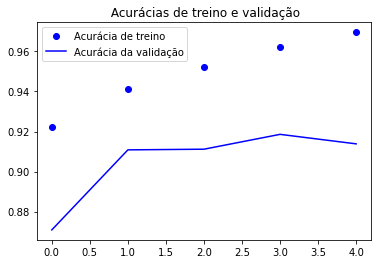

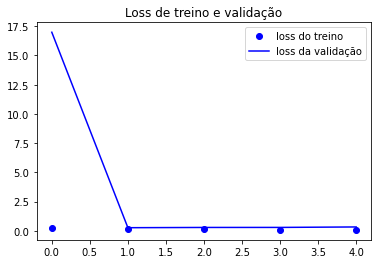

In [39]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Acurácia de treino')
plt.plot(epochs, val_accuracy, 'b', label='Acurácia da validação')
plt.title(' Acurácias de treino e validação')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='loss do treino')
plt.plot(epochs, val_loss, 'b', label='loss da validação')
plt.title('Loss de treino e validação')
plt.legend()
plt.show()

## Acurácia do Classificador (teste)

In [40]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)
print('loss do teste:', test_eval[0])
print('Acurácia do teste:', test_eval[1])


loss do teste: 0.3221355080604553
Acurácia do teste: 0.9151999950408936


In [41]:
predicted_classes = full_model.predict(test_data)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Found 9136 correct labels


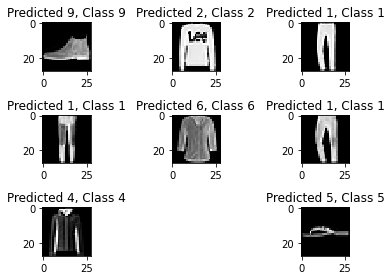

In [43]:
correct = np.where(predicted_classes==test_labels)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found 864 incorrect labels


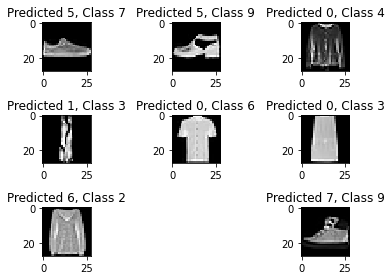

In [44]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()


## Relatorio do SKLearn

In [45]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.82      0.88      0.85      1000
     Class 1       0.99      0.98      0.98      1000
     Class 2       0.88      0.89      0.88      1000
     Class 3       0.92      0.90      0.91      1000
     Class 4       0.82      0.91      0.86      1000
     Class 5       0.99      0.97      0.98      1000
     Class 6       0.83      0.71      0.76      1000
     Class 7       0.94      0.96      0.95      1000
     Class 8       0.99      0.98      0.98      1000
     Class 9       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



URL de download das imagens:
https://github.com/zalandoresearch/fashion-mnist